## Using Transformer for generating simple python code
- Input file is from the final assignment
- Tokenize and create batches for training, dev and test
- Modify the loss function to factor max length of sequence

## Import Library

In [1]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import csv
import random
import re
import os
import math
import time
import unicodedata
import codecs
from io import open
import itertools


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.jit import script, trace

import torchtext.legacy
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator,TabularDataset
from torchtext.data.functional import load_sp_model


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import tokenize

In [3]:
spacy_en = spacy.load('en')

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Clean and prepare data

In [5]:
# Define maximum length of input text or program string to consider for training
MAX_LENGTH = 300

#Input file name
python_data_file = '/content/1_formatted_noblank_lines.py'

# Files names for processed output
two_column_csv = '/content/2_column_out.csv'
cleaned_input_file = '/content/src_trg_cols_trimmed.csv'

In [6]:
## Split function to convert the given input python file into 2 columns csv - 
##      First Column - input text identified by lines starting with # sign in first column
##      Second Column - python code as string until the next # sign in first column is reached
def create_2col_file(infile, outfile):

    lines = open(infile, mode="r", encoding="utf-8").readlines()

    i = 0
    code = ""
    rows_list = []  #list that will be written as csv file
    for line in lines:
        # print(line)
        if i == 0: # For the first text line, save it to text field
            text = re.sub('[^a-zA-Z]', ' ', line[:5]) + line[5:]
            i += 1
        elif line[0] == "#" and code == "":  # Skip lines that are comments only without code
            text = re.sub('[^a-zA-Z]', ' ', line[:5]) + line[5:] # get rid of # and other numbers
            i += 1
            continue
        elif line[0] == "#":
            rows_list.append([text.strip(), code.strip()])
            text = re.sub('[^a-zA-Z]', ' ', line[:5]) + line[5:] # get rid of # and other numbers
            code = ""
            i += 1
        elif line.strip()[0] == "#":    ## ignore lines with comments only 
            i += 1
            continue
        else:
            code = code + line
            i += 1
    # append the last text and code
    rows_list.append([text.strip(), code.strip()])
    print("Total Number of rows", len(rows_list))

    with open(outfile, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(rows_list)
      
    return

In [7]:
# Process the input file to a csv file
create_2col_file(python_data_file, two_column_csv)

Total Number of rows 4343


In [8]:
header_list = ["src", "trg"]
df = pd.read_csv(two_column_csv, encoding='utf-8', names=header_list)

In [9]:
df.head()

,src,trg
0,write a python program to add two numbers,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu..."
2,write a program to find and print the largest ...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
3,write a program to find and print the smallest...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,Write a python function to merge two given lis...,"def merge_lists(l1, l2):\n return l1 + l2"


In [10]:
## Find out the max string lengths of each column
measurer = np.vectorize(len)
res1 = measurer(df.values.astype(str)).max(axis=0)
res1

array([ 309, 5375])

In [11]:
# keep only rows that meets maximum legth limit
mask = ((df['src'].str.len() <= MAX_LENGTH) & (df['trg'].str.len() <= MAX_LENGTH))
df_trimmed = df.loc[mask]

df_trimmed.count()

src    3868
trg    3868
dtype: int64

In [12]:
# Save trimmed data to a new file
df_trimmed.to_csv(cleaned_input_file, index=False)

## Create Data Iterator

In [90]:
# Constants used for tokenizing and detokenizing the python code
INDENT = "<ind>"
DEDENT = "<ded>"
EOL = "<eol>"
NEWLINE = "\n"
TAB = "    "

def detokenize_py(input, eol=EOL):
    input_string = " ".join(x for x in input).replace(eol + " ", NEWLINE)
    #print(input_string)
    lines = input_string.split(NEWLINE+' ')
    output_str = ""
    cnt_ind = 0
    for line in lines:
        #print(line)
        if INDENT in line:
            cnt_ind += line.count(INDENT)
            line = TAB * cnt_ind + line.replace(INDENT + " ", "", 10)
        elif DEDENT in line:
            cnt_ind -= line.count(DEDENT)
            line = TAB * cnt_ind + line.replace(DEDENT + " ", "", 10).replace(DEDENT, "", 10)
        else:
            line = TAB * cnt_ind + line
        output_str += line + NEWLINE
    return output_str

In [79]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]
    #return sp.encode(text, out_type=str)

def tokenize_py(text):
    """
    Tokenize python code from string to list of strings using python tokenizer
    """
    lines = iter(text.splitlines(True))
    #print(text)
    try:
      tokens = tokenize.generate_tokens(lines.__next__)
    except:
      print(text)
      raise exception("missing valid python code!")
    output = []
    for token in tokens:
        # print(str(token), str(token.start[0]))
        if token.type == tokenize.NEWLINE:
            value = NEWLINE
        elif token.type == tokenize.ENDMARKER:
            continue
        elif token.type == tokenize.INDENT:
            value = INDENT
        elif token.type == tokenize.DEDENT:
            value = DEDENT
        elif token.type == tokenize.COMMENT:
            continue
        elif token.type == tokenize.NL:
            continue
        else:
            value = token[1]
        output = output + [value]
    return output

In [15]:
src = Field(tokenize = tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

trg = Field(tokenize = tokenize_py, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            #lower = True, 
            batch_first = True)

fields = {'src' : ('src', src),
          'trg' : ('trg', trg)}

In [16]:
qa_data  = TabularDataset(
                            path = cleaned_input_file,
                            format = 'csv',
                            fields = fields
                            )

In [17]:
train_data, valid_data, test_data = qa_data.split([0.8,.1,.1])

In [18]:
src.build_vocab(train_data, min_freq = 1)
trg.build_vocab(train_data, min_freq = 1)

In [19]:
len(src.vocab), len(trg.vocab)

(1783, 4552)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device,
     sort_within_batch = True,
     sort_key = lambda x: len(x.src))

cuda


In [21]:
# Get the first batch from iterator
for i, batch in enumerate(train_iterator):
    break


In [22]:
# Check batch dimensions
batch.trg.size(), batch.src.size()

(torch.Size([128, 123]), torch.Size([128, 13]))

In [23]:
# Look at a source record
[src.vocab.itos[i] for i in batch.src[0]]

['<sos>',
 'write',
 'a',
 'function',
 'to',
 'rotate',
 'string',
 'right',
 'by',
 'a',
 'given',
 'length',
 '<eos>']

In [25]:
# Look at the corresponding target record without padding (its id is 1)
[trg.vocab.itos[i] for i in batch.trg[0] if i != 1]

['<sos>',
 'def',
 'rotate_right',
 '(',
 'input',
 ',',
 'd',
 ')',
 ':',
 '\n',
 '<ind>',
 'Rfirst',
 '=',
 'input',
 '[',
 '0',
 ':',
 'len',
 '(',
 'input',
 ')',
 '-',
 'd',
 ']',
 '\n',
 'Rsecond',
 '=',
 'input',
 '[',
 'len',
 '(',
 'input',
 ')',
 '-',
 'd',
 ':',
 ']',
 '\n',
 'return',
 '(',
 'Rsecond',
 '+',
 'Rfirst',
 ')',
 '\n',
 '<ded>',
 '<eos>']

## Create Model

In [26]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 300):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [28]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [29]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [30]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [31]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [32]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        #print(trg_mask.sum())
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Train and Evaluate the Model

In [33]:
INPUT_DIM = len(src.vocab)
OUTPUT_DIM = len(trg.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8 #8
DEC_HEADS = 8 #8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [34]:
SRC_PAD_IDX = src.vocab.stoi[src.pad_token]
TRG_PAD_IDX = trg.vocab.stoi[trg.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,078,088 trainable parameters


In [36]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [37]:
# This code is from openNMT repo https://github.com/OpenNMT/OpenNMT-py/blob/e8622eb5c6117269bb3accd8eb6f66282b5e67d9/onmt/utils/loss.py#L186
class LabelSmoothingLoss(nn.Module):
    """
    With label smoothing,
    KL-divergence between q_{smoothed ground truth prob.}(w)
    and p_{prob. computed by model}(w) is minimized.
    """
    def __init__(self, label_smoothing, tgt_vocab_size, ignore_index=-100):
        assert 0.0 < label_smoothing <= 1.0
        self.ignore_index = ignore_index
        super(LabelSmoothingLoss, self).__init__()

        smoothing_value = label_smoothing / (tgt_vocab_size - 2)
        one_hot = torch.full((tgt_vocab_size,), smoothing_value)
        one_hot[self.ignore_index] = 0
        self.register_buffer('one_hot', one_hot.unsqueeze(0))

        self.confidence = (1.0 - label_smoothing)

    def forward(self, output, target):
        """
        output (FloatTensor): batch_size x n_classes
        target (LongTensor): batch_size
        """
        model_prob = self.one_hot.repeat(target.size(0), 1)
        model_prob.scatter_(1, target.unsqueeze(1), self.confidence)
        model_prob.masked_fill_((target == self.ignore_index).unsqueeze(1), 0)

        return F.kl_div(output, model_prob, reduction='batchmean')

label_smoothing = 0.1
tgt_vocab_size = len(trg.vocab)
#LSloss = LabelSmoothingLoss(label_smoothing, tgt_vocab_size, ignore_index=TRG_PAD_IDX)

In [38]:
model.apply(initialize_weights);

In [39]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [40]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
#criterion = LabelSmoothingLoss(label_smoothing, tgt_vocab_size, ignore_index=TRG_PAD_IDX).cuda()

In [41]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        #print(trg.shape)
        seq_len = trg.shape[1] -1 
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        #print(output.shape,trg.shape)    
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()/ seq_len
        
    return epoch_loss / len(iterator)

In [42]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            seq_len = trg.shape[1] -1

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()/seq_len
        
    return epoch_loss / len(iterator)

In [43]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [44]:
N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 4s
	Train Loss: 0.054 | Train PPL:   1.056
	 Val. Loss: 0.047 |  Val. PPL:   1.048
Epoch: 02 | Time: 0m 4s
	Train Loss: 0.037 | Train PPL:   1.038
	 Val. Loss: 0.035 |  Val. PPL:   1.036
Epoch: 03 | Time: 0m 4s
	Train Loss: 0.029 | Train PPL:   1.030
	 Val. Loss: 0.029 |  Val. PPL:   1.030
Epoch: 04 | Time: 0m 4s
	Train Loss: 0.026 | Train PPL:   1.026
	 Val. Loss: 0.026 |  Val. PPL:   1.027
Epoch: 05 | Time: 0m 4s
	Train Loss: 0.023 | Train PPL:   1.024
	 Val. Loss: 0.024 |  Val. PPL:   1.024
Epoch: 06 | Time: 0m 4s
	Train Loss: 0.021 | Train PPL:   1.022
	 Val. Loss: 0.023 |  Val. PPL:   1.023
Epoch: 07 | Time: 0m 4s
	Train Loss: 0.020 | Train PPL:   1.020
	 Val. Loss: 0.021 |  Val. PPL:   1.021
Epoch: 08 | Time: 0m 4s
	Train Loss: 0.019 | Train PPL:   1.019
	 Val. Loss: 0.020 |  Val. PPL:   1.020
Epoch: 09 | Time: 0m 4s
	Train Loss: 0.018 | Train PPL:   1.018
	 Val. Loss: 0.019 |  Val. PPL:   1.019
Epoch: 10 | Time: 0m 4s
	Train Loss: 0.017 | Train PPL:   1.017


In [45]:
model.load_state_dict(torch.load('model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.012 | Test PPL:   1.012 |


In [46]:
## Display Attention

In [47]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 500):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    print(trg_indexes)
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [97]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize= (35, 75)) #(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize= 12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [98]:
example_idx = 2

src_1 = vars(train_data.examples[example_idx])['src']
trg_1 = vars(train_data.examples[example_idx])['trg']

print(f'src = {src_1}')
print(f'trg = {trg_1}')

src = ['write', 'a', 'python', 'function', 'to', 'find', 'element', 'occurring', 'odd', 'number', 'of', 'times', 'in', 'a', 'list']
trg = ['def', 'find_odd_occurring', '(', 'alist', ')', ':', '\n', '<ind>', 'ans', '=', '0', '\n', 'for', 'element', 'in', 'alist', ':', '\n', '<ind>', 'ans', '^=', 'element', '\n', '<ded>', 'return', 'ans', '\n', '<ded>']


In [99]:
translation, attention = translate_sentence(src_1, src, trg, model, device)

print(f'predicted trg = {translation}')

[2, 17, 2436, 5, 196, 6, 8, 4, 11, 534, 9, 22, 4, 21, 319, 20, 196, 8, 4, 11, 534, 530, 319, 4, 10, 18, 534, 4, 10, 3]
predicted trg = ['def', 'find_odd_occurring', '(', 'alist', ')', ':', '\n', '<ind>', 'ans', '=', '0', '\n', 'for', 'element', 'in', 'alist', ':', '\n', '<ind>', 'ans', '^=', 'element', '\n', '<ded>', 'return', 'ans', '\n', '<ded>', '<eos>']


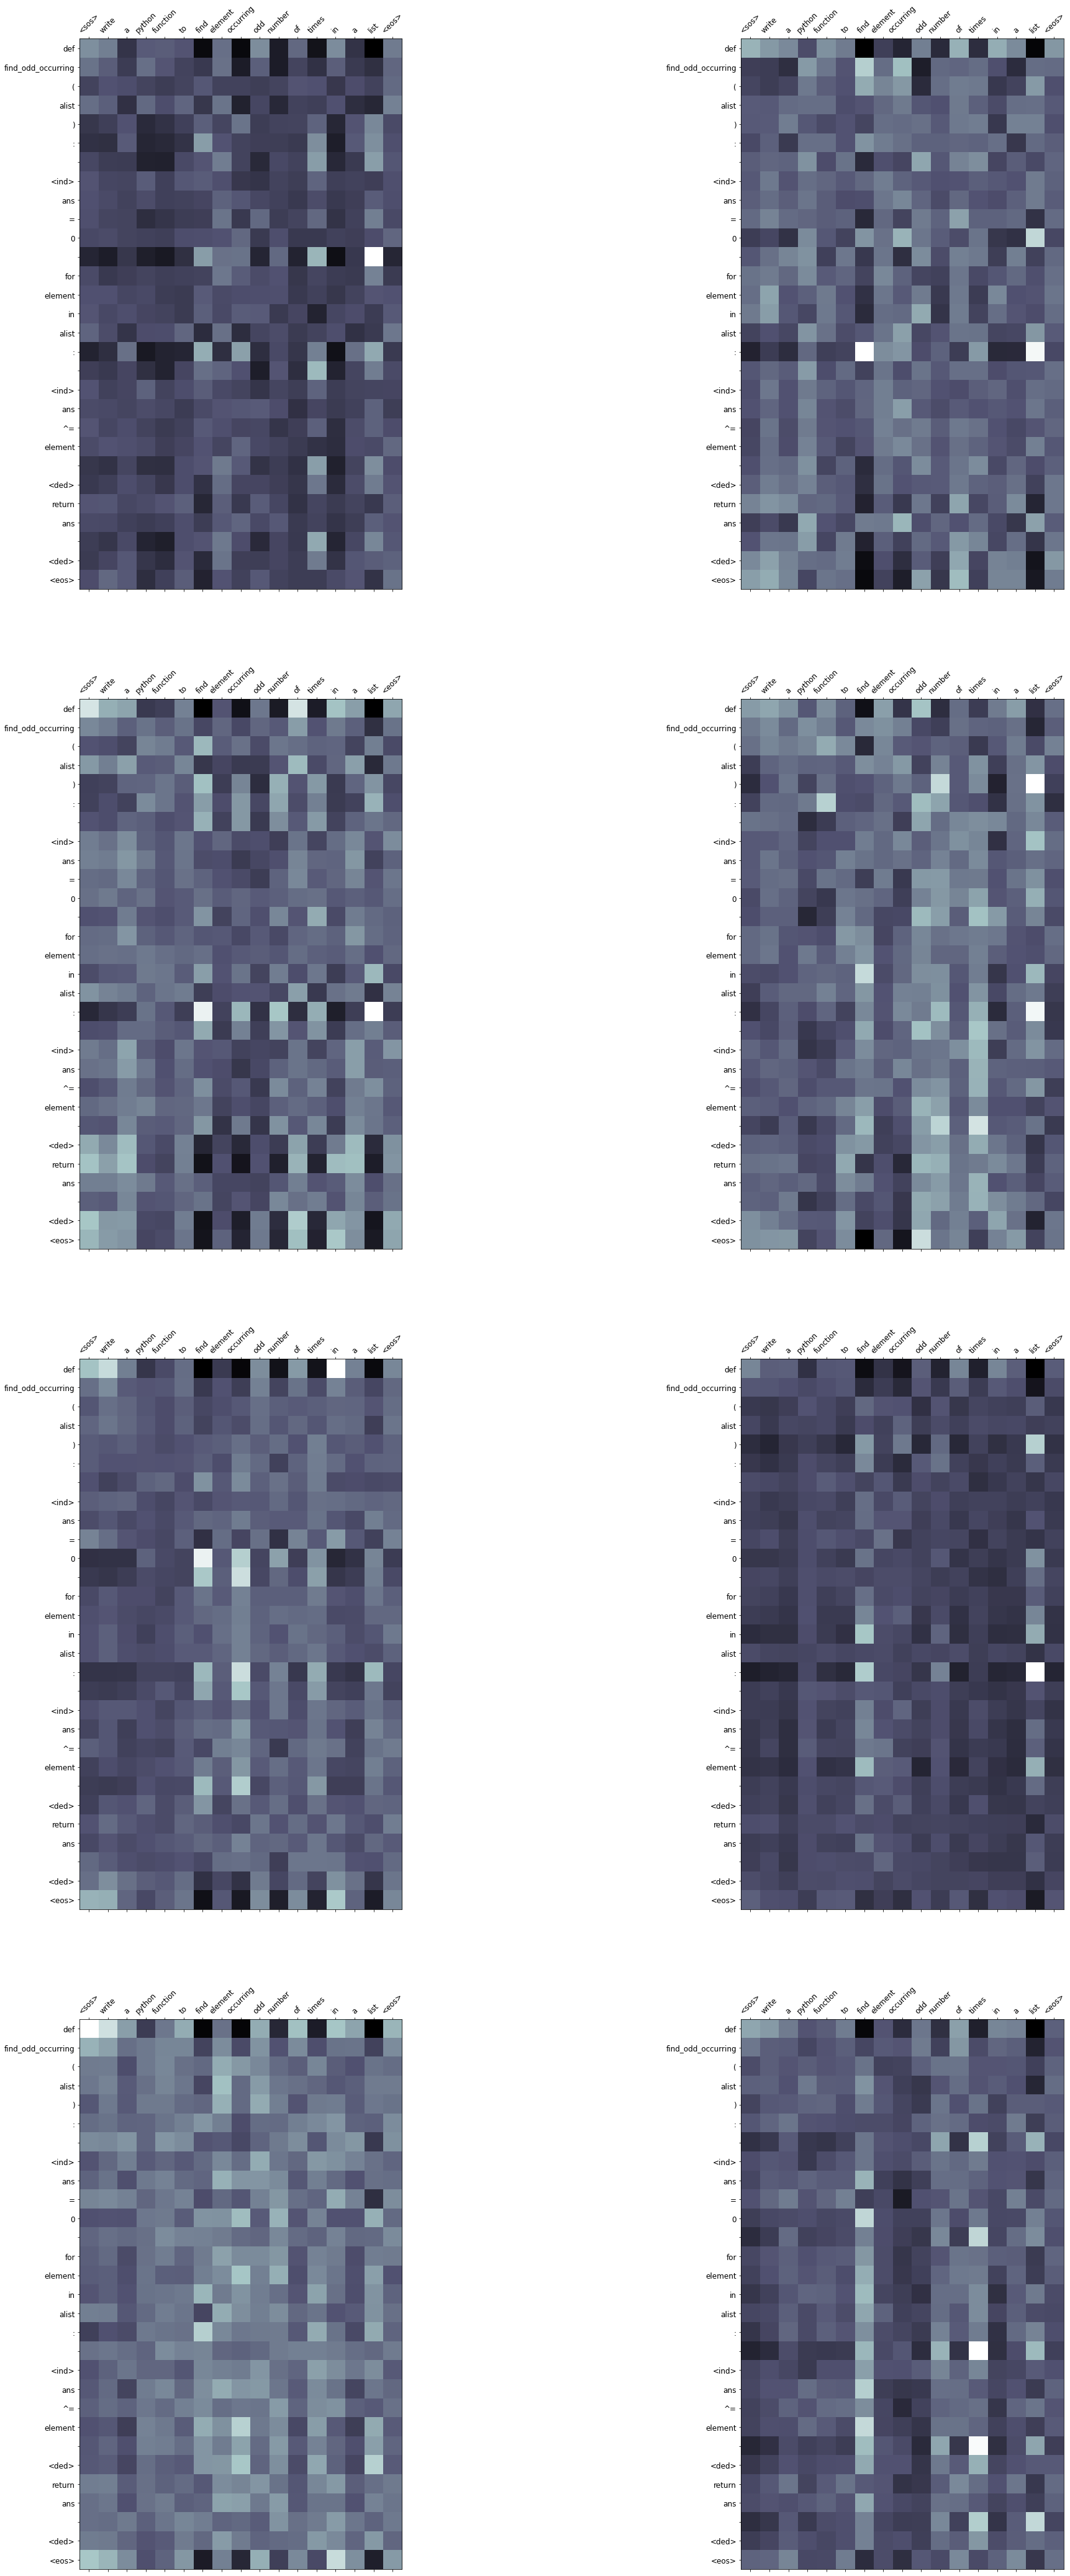

In [100]:
display_attention(src_1, translation, attention)

In [101]:
example_idx = 98

src_1 = vars(valid_data.examples[example_idx])['src']
trg_1 = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src_1}')
print(f'trg = {trg_1}')

src = ['write', 'a', 'python', 'program', ' ', 'to', 'extract', 'domain', 'name', 'from', 'email', 'address', 'and', 'print', 'it']
trg = ['test_str', '=', "'md.shakiluzzaman@gmail.com'", '\n', 'print', '(', '"The original string is : "', '+', 'str', '(', 'test_str', ')', ')', '\n', 's', '=', 'test_str', '.', 'split', '(', "'@'", ')', '\n', 'print', '(', 's', '[', '1', ']', ')', '\n']


In [102]:
translation, attention = translate_sentence(src_1, src, trg, model, device)

print(f'predicted trg = {translation}')

[2, 40, 152, 4, 17, 2296, 5, 6, 8, 4, 11, 94, 166, 40, 152, 4, 331, 9, 1454, 4, 189, 1328, 15, 691, 9, 1454, 4, 189, 1328, 15, 1329, 5, 331, 6, 134, 46, 8, 4, 11, 46, 9, 43, 5, 46, 6, 4, 85, 9, 43, 5, 46, 6, 4, 85, 9, 46, 12, 8, 13, 4, 469, 12, 22, 13, 4, 85, 9, 85, 4, 83, 85, 31, 22, 8, 4, 11, 469, 9, 85, 15, 84, 5, 46, 6, 4, 10, 10, 14, 5, 1848, 7, 469, 12, 22, 13, 6, 4, 10, 3]
predicted trg = ['import', 're', '\n', 'def', 'check_ip', '(', ')', ':', '\n', '<ind>', 'from', 'itertools', 'import', 're', '\n', 'url', '=', '"http://checkip.dyndns.org"', '\n', 'with', 'ur', '.', 'request', '=', '"http://checkip.dyndns.org"', '\n', 'with', 'ur', '.', 'urlopen', '(', 'url', ')', 'as', 's', ':', '\n', '<ind>', 's', '=', 'str', '(', 's', ')', '\n', 'temp', '=', 'str', '(', 's', ')', '\n', 'temp', '=', 's', '[', ':', ']', '\n', 'ip', '[', '0', ']', '\n', 'temp', '=', 'temp', '\n', 'while', 'temp', '==', '0', ':', '\n', '<ind>', 'ip', '=', 'temp', '.', 'append', '(', 's', ')', '\n', '<ded>', '<d

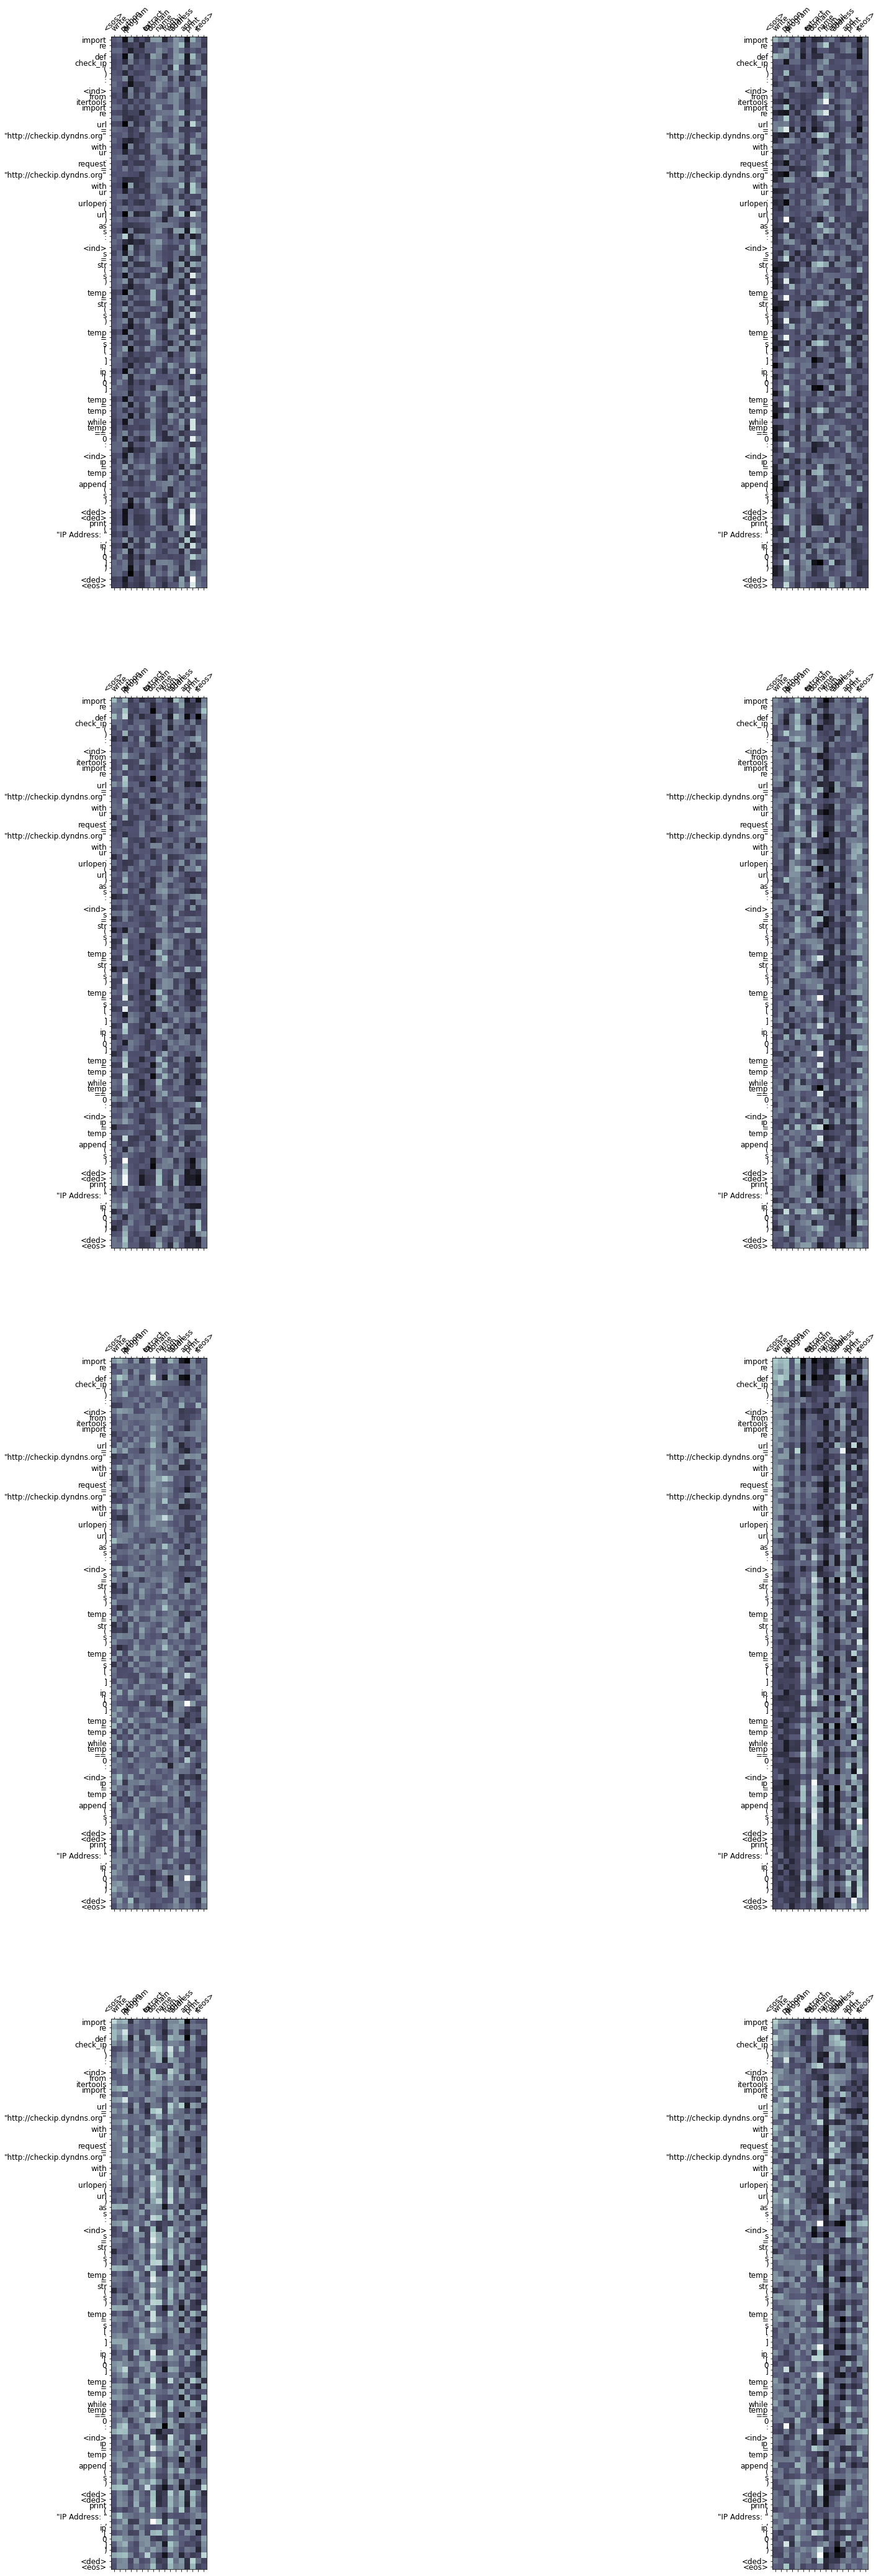

In [103]:
display_attention(src_1, translation, attention)

## Chatbot using Trained Model

In [94]:
def generate_words(sentence, sentence_field, target_field, model, device,max_length=200):
  model.eval()

  #tokens = [token.lower() for token in sentence]
  #tokens = [token for token in sentence]
  tokens = sentence.lower().split()
  #print(tokens)
  tokens = [sentence_field.init_token] + tokens + [sentence_field.eos_token]
  src_indexes = [sentence_field.vocab.stoi[token] for token in tokens]
  #print(src_indexes)
  src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
  src_mask = model.make_src_mask(src_tensor)

  with torch.no_grad():
      enc_src = model.encoder(src_tensor, src_mask)

  trg_indexes = [sentence_field.vocab.stoi[sentence_field.init_token]]

  for i in range(max_length):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == sentence_field.vocab.stoi[sentence_field.eos_token]:
            break
    
  #trg_tokens = [sentence_field.vocab.itos[i] for i in trg_indexes]
  trg_tokens = [target_field.vocab.itos[i] for i in trg_indexes]
  return trg_tokens[1:]

In [95]:
def chatbot(sentence_field, target_field, model, device):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            #input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = generate_words(input_sentence, sentence_field, target_field, model, device,max_length=200)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == '<eos>' or x == '<pad>' or x == '<unk>')]
            #print('Bot:', ('~'.join(output_words)).replace('<eol>', '\n'))
            #print(output_words)
            print(detokenize_py(output_words))
            #print('Bot:', sp.decode(output_words).replace('<EOL>', '\n').replace('<INDENT>', '\t'))

        except KeyError:
            print("Error: Encountered unknown word.")

In [96]:
model.load_state_dict(torch.load('model.pt'))
chatbot(src, trg, model, device)

> write a program to add two numbers
num1 = 1.5 
num2 = 6.3 
sum = num1 + num2 
print ( f'Sum: {sum}' ) 


> write a function to add two numbers
def add_two_numbers ( num1 , num2 ) : 
    sum = num1 + num2 
    return sum 


> write a function to print area of circle
def findArea ( r ) : 
    PI = 3.142 
    return PI * ( r * r ) 


> write a program to reverse a string
str1 = "PYnative" 
print ( "Original String is:" , str1 ) 
str1 = str1 [ : : - 1 ] 
print ( "Reversed String is:" , str1 ) 


> write a function to reverse a string
def reverse_string ( string ) : 
    return string [ : : - 1 ] 


> write a program to print largest of three numbers
num1 = 10 
num2 = 12 
num3 = 14 
if ( num1 >= num1 >= num2 ) and ( num2 >= num3 ) : 
    largest = num1 
elif ( num2 >= num3 ) : 
    largest = num1 
elif ( num2 >= num3 ) and ( num2 >= num3 ) : 
    largest = num3 
else : 
    largest = num3 
print ( f'largest:{largest}' ) 


> write a program to print the smallest of the three numbers
num1 